In [124]:
import pandas as pd
import numpy as np

# Cargar el dataset
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
data = pd.read_csv(url)

In [125]:
# Preparar los datos usando melt para transformar el DataFrame
data_melted = data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                         var_name='Date', value_name='ConfirmedCases')

In [126]:
# Convertir la columna 'Date' a formato datetime
data_melted['Date'] = pd.to_datetime(data_melted['Date'],format='%m/%d/%y')

In [127]:

# Filtrar filas con casos confirmados no nulos
data_melted = data_melted[data_melted['ConfirmedCases'].notna()]

In [128]:
# Crear una copia del DataFrame
data_melted_copy = data_melted.copy()

In [129]:
# Eliminar columnas irrelevantes
data_melted_copy.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)

In [130]:
# Calcular nuevos casos
data_melted_copy['NewConfirmedCases'] = data_melted_copy.groupby('Country/Region')['ConfirmedCases'].diff().fillna(0)

In [131]:
# Agrupar por país y fecha, y sumar los nuevos casos confirmados
country_daily_cases = data_melted_copy.groupby(['Country/Region', 'Date'], as_index=False)['NewConfirmedCases'].sum()


In [132]:
# Crear columnas para mes y año
country_daily_cases['Month'] = country_daily_cases['Date'].dt.month
country_daily_cases['Year'] = country_daily_cases['Date'].dt.year

In [133]:
# Agrupar por país, año y mes, y sumar los nuevos casos
monthly_country_cases = country_daily_cases.groupby(['Country/Region', 'Year', 'Month'], as_index=False)['NewConfirmedCases'].sum()

In [134]:
# Convertir el índice a MultiIndex
monthly_country_cases.set_index(['Country/Region', 'Year', 'Month'], inplace=True)

In [135]:
# Definir una lista de países/ regiones a eliminar
countries_to_remove = ['Diamond Princess', 'MS Zaandam', 'Summer Olympics 2020', 'Winter Olympics 2022']

In [136]:
# Filtrar el DataFrame para eliminar los países no deseados
monthly_country_cases_filtered = monthly_country_cases[~monthly_country_cases.index.get_level_values('Country/Region').isin(countries_to_remove)]

In [137]:
# 1. Encontrar el mes con el mayor número de contagios
monthly_cases_summary = monthly_country_cases_filtered.groupby(level=['Year', 'Month']).sum()

# Obtener el mes con el máximo de casos
max_cases_month = monthly_cases_summary.loc[monthly_cases_summary['NewConfirmedCases'].idxmax()]

# Mostrar el mes y año con el mayor número de NewConfirmedCases
print(f"El mes con el mayor número de contagios es: {max_cases_month.name[1]}/{max_cases_month.name[0]} con {max_cases_month['NewConfirmedCases']} casos.")

El mes con el mayor número de contagios es: 1/2022 con 87136560.0 casos.


In [138]:
# 2. Encontrar el país que reportó más contagios en ese mes
country_most_cases = monthly_country_cases_filtered[
    (monthly_country_cases_filtered.index.get_level_values('Year') == max_cases_month.name[0]) &
    (monthly_country_cases_filtered.index.get_level_values('Month') == max_cases_month.name[1])
]

# Utilizar loc y idxmax para encontrar el país con el mayor número de casos
top_country = country_most_cases.loc[country_most_cases['NewConfirmedCases'].idxmax()]

# Mostrar el país con más contagios en ese mes
print(f"El país con más contagios en ese mes fue: {top_country.name[0]} con {top_country['NewConfirmedCases']} casos.")



El país con más contagios en ese mes fue: US con 20336435.0 casos.


In [140]:
# 3. Encontrar el país con el menor número total de casos reportados
total_cases_per_country = monthly_country_cases_filtered.groupby(level='Country/Region').sum()
min_case_country = total_cases_per_country.loc[total_cases_per_country['NewConfirmedCases'].idxmin()]

# Mostrar el país con el menor número total de casos reportados
print(f"El país con el menor número de casos reportados hasta la fecha es: {min_case_country.name} con un total de {min_case_country['NewConfirmedCases']} casos.")

El país con el menor número de casos reportados hasta la fecha es: Korea, North con un total de 1.0 casos.


 **Parte 2:**

In [147]:
import matplotlib.pyplot as plt

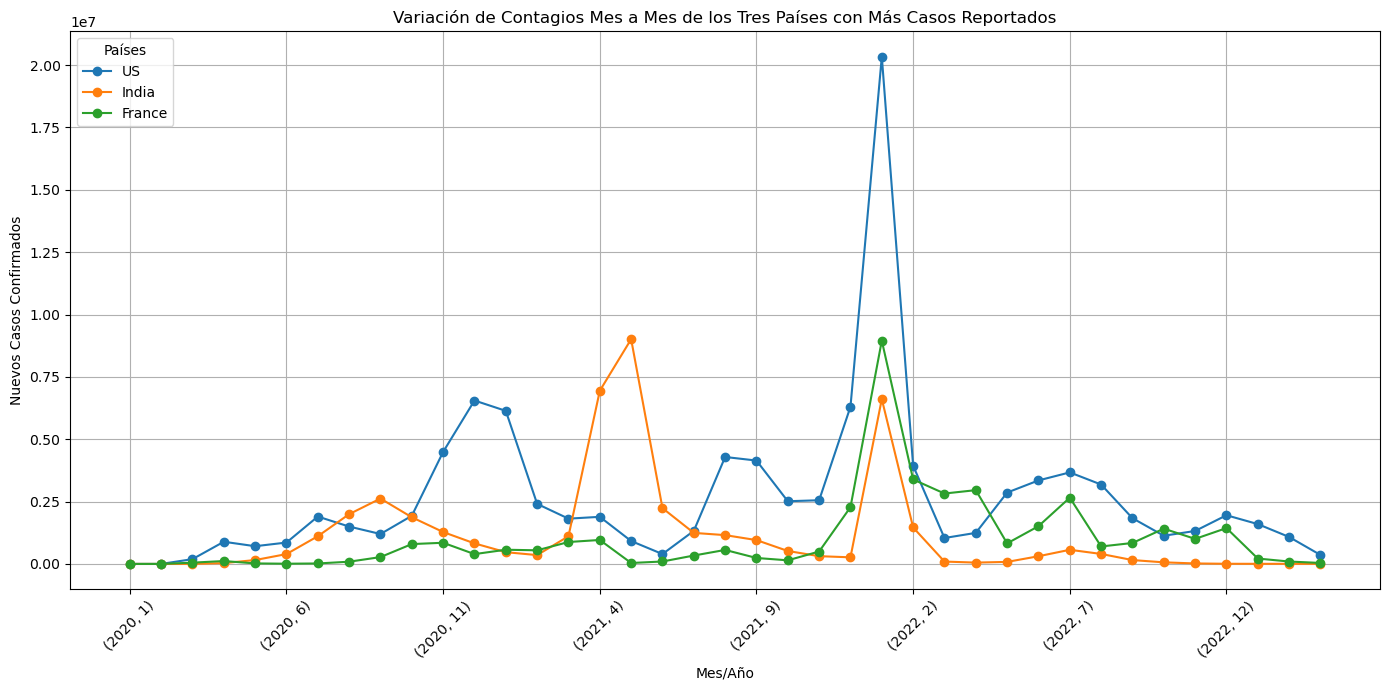

In [157]:
# 1. Construir una gráfica que muestre la variación de contagios, mes a mes, de los tres países con más casos reportados.
top_countries = monthly_country_cases_filtered.groupby(level='Country/Region').sum()['NewConfirmedCases'].nlargest(3).index.tolist()

plt.figure(figsize=(14, 7))
for country in top_countries:
    monthly_country_cases_filtered.loc[country]['NewConfirmedCases'].plot(label=country, marker='o')

plt.title('Variación de Contagios Mes a Mes de los Tres Países con Más Casos Reportados')
plt.xlabel('Mes/Año')
plt.ylabel('Nuevos Casos Confirmados')
plt.xticks(rotation=45)
plt.legend(title='Países', loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [159]:
print(top_countries)

['US', 'India', 'France']


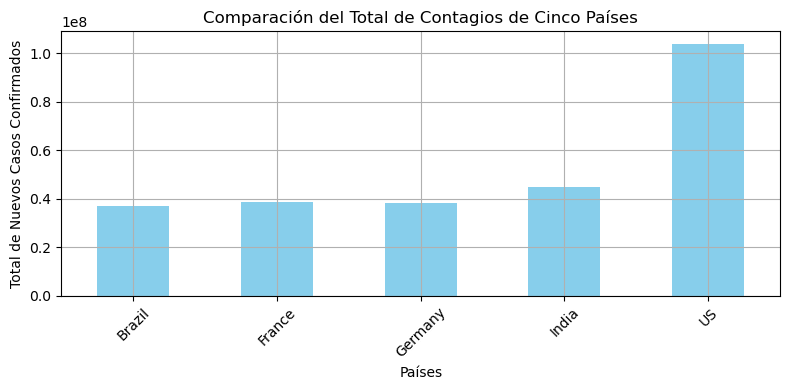

                NewConfirmedCases
Country/Region                   
Brazil                 37076053.0
France                 38618509.0
Germany                38249060.0
India                  44690738.0
US                    103802701.0


In [160]:
# 2. Construir una gráfica que muestre una comparación del total de contagios de cinco países.

## En este punto quise elegir los 5 paises con mayor numero de contagios 

five_countries = monthly_country_cases_filtered.groupby(level='Country/Region').sum()['NewConfirmedCases'].nlargest(5).index

total_cases_five = monthly_country_cases_filtered.loc[five_countries].groupby(level='Country/Region').sum()

plt.figure(figsize=(8, 4))
total_cases_five['NewConfirmedCases'].plot(kind='bar', color='skyblue')
plt.title('Comparación del Total de Contagios de Cinco Países')
plt.xlabel('Países')
plt.ylabel('Total de Nuevos Casos Confirmados')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

print(total_cases_five)

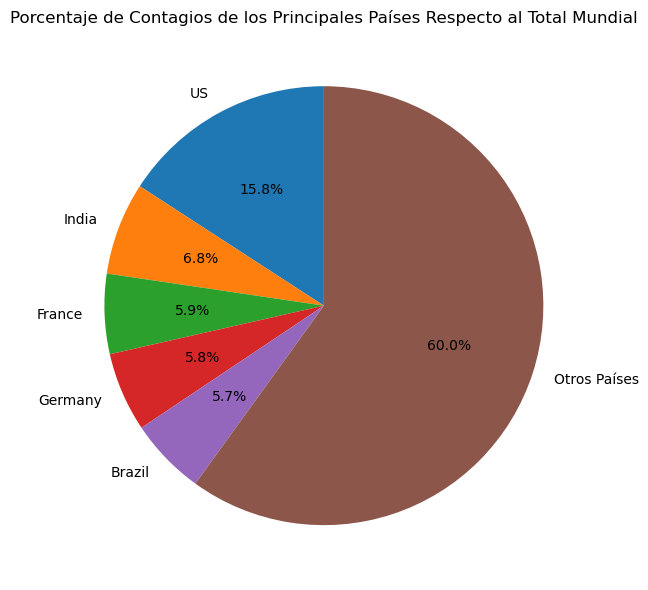

In [162]:
# 3. Usando los países elegidos en el punto anterior, construir una gráfica que muestre el porcentaje de contagios de cada país con respecto al total de contagios en el mundo.
# Primero, seleccionamos los cinco países de mayor número de casos confirmados
# Extraer el total global de casos
total_global_cases = monthly_country_cases_filtered['NewConfirmedCases'].sum()

# 1. Encontrar los cinco países con más casos
five_countries = monthly_country_cases_filtered.groupby(level='Country/Region').sum()['NewConfirmedCases'].nlargest(5)

# 2. Calcular el porcentaje de cada país respecto al total global
percentages = (five_countries / total_global_cases) * 100


# 3. Incluir el porcentaje de "Otros Países"
other_cases_percentage = 100 - percentages.sum()

# Ajuste utilizando pd.concat en lugar de .append()
percentages = pd.concat([percentages, pd.Series({'Otros Países': other_cases_percentage})])




# 4. Crear la gráfica de pastel
plt.figure(figsize=(10, 6))
percentages.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de Contagios de los Principales Países Respecto al Total Mundial')
plt.ylabel('')  # Ocultar la etiqueta del eje y
plt.tight_layout()
plt.show()

In [163]:
print(total_global_cases)

655309326.0


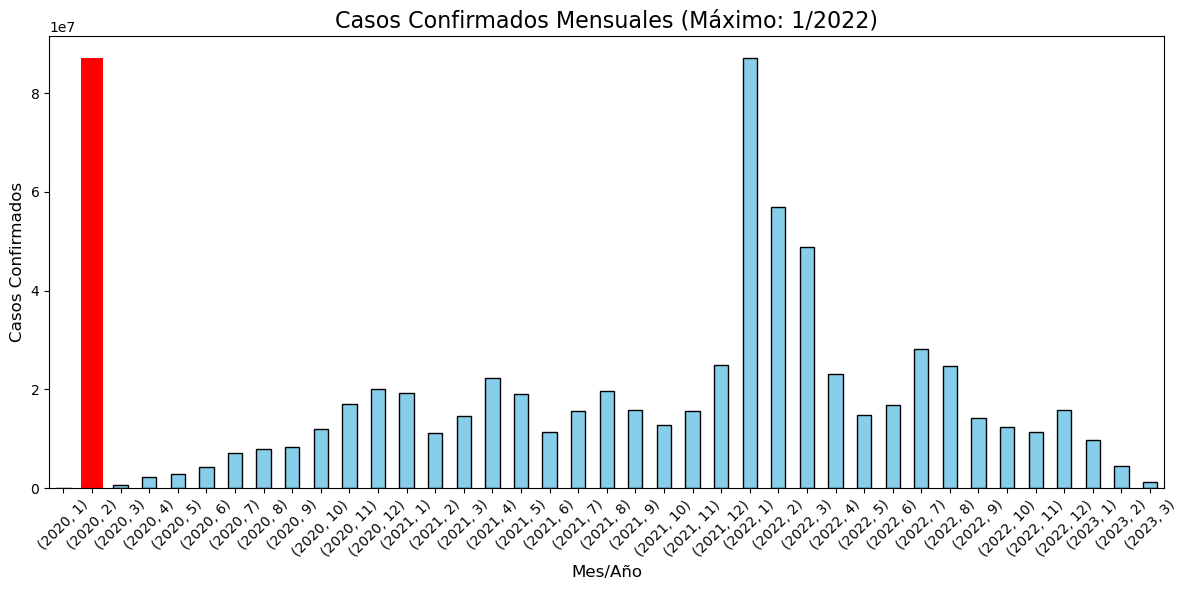

In [164]:
import matplotlib.pyplot as plt

# Extraer el mes y año del máximo de casos
max_month = max_cases_month.name[1]
max_year = max_cases_month.name[0]

# Graficar todos los casos por mes y año
plt.figure(figsize=(12, 6))
monthly_cases_summary['NewConfirmedCases'].plot(kind='bar', color='skyblue', edgecolor='black')

# Resaltar el mes con el mayor número de casos en rojo
highlight = monthly_cases_summary['NewConfirmedCases'].idxmax()
plt.bar(highlight, monthly_cases_summary['NewConfirmedCases'].loc[highlight], color='red')

# Etiquetas y título
plt.title(f'Casos Confirmados Mensuales (Máximo: {max_month}/{max_year})', fontsize=16)
plt.xlabel('Mes/Año', fontsize=12)
plt.ylabel('Casos Confirmados', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


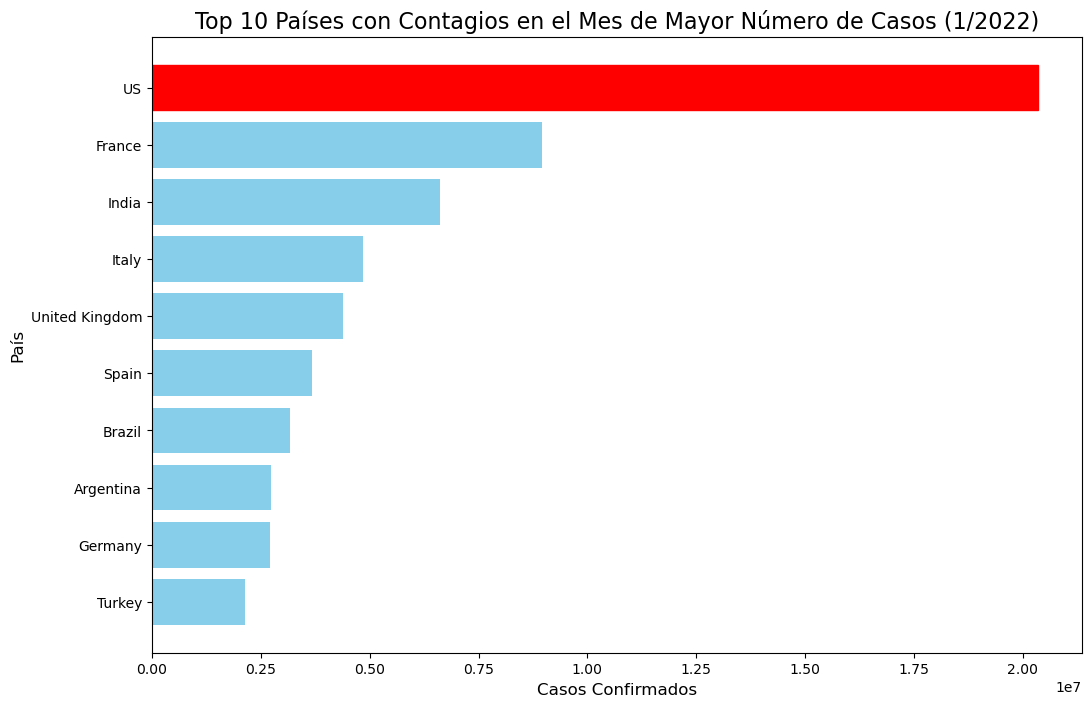

In [165]:
# Ordenar y filtrar los 10 países con más casos
top_10_countries = top_month_cases.nlargest(10, 'NewConfirmedCases')

# Crear una gráfica de barras horizontal
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_countries['Country/Region'], top_10_countries['NewConfirmedCases'], color='skyblue')
for bar, country in zip(bars, top_10_countries['Country/Region']):
    if country == top_country_name:
        bar.set_color('red')

# Etiquetas y título
plt.xlabel('Casos Confirmados', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.title(f'Top 10 Países con Contagios en el Mes de Mayor Número de Casos ({max_month}/{max_year})', fontsize=16)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el país con más casos


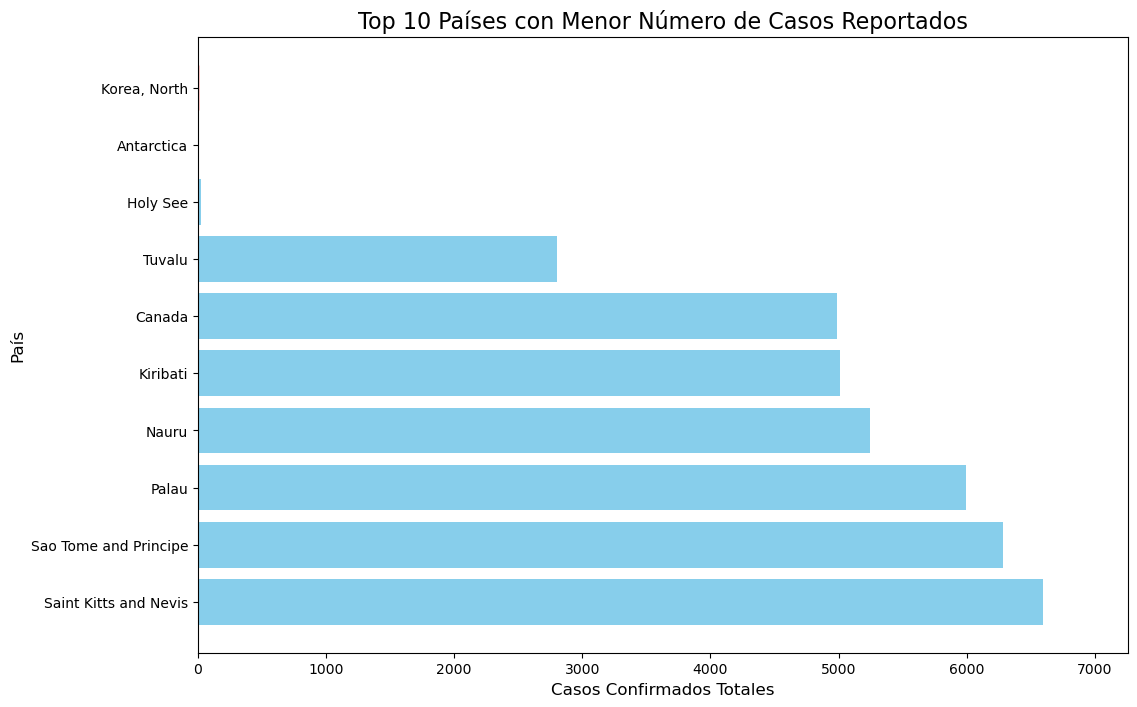

In [168]:
# Filtrar los 10 países con el menor número total de casos
bottom_10_countries = total_cases_per_country.nsmallest(10, 'NewConfirmedCases').reset_index()

# Crear una gráfica de barras horizontal
plt.figure(figsize=(12, 8))
bars = plt.barh(bottom_10_countries['Country/Region'], bottom_10_countries['NewConfirmedCases'], color='skyblue')
for bar, country in zip(bars, bottom_10_countries['Country/Region']):
    if country == min_case_country.name:
        bar.set_color('red')  # Resaltar el país con el menor número total de casos

# Etiquetas y título
plt.xlabel('Casos Confirmados Totales', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.title('Top 10 Países con Menor Número de Casos Reportados', fontsize=16)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el país con menos casos esté arriba

# Ajuste del límite en el eje X para resaltar los valores bajos
plt.xlim(0, bottom_10_countries['NewConfirmedCases'].max() * 1.1)

plt.show()

